# Forecasting non-stationary time series

#### In chapters 4, 5, and 6 we covered the moving average model, MA(q)); the autoregressive model, AR(p)); and the ARMA model, ARMA(p,q). We saw how these models can only be used for stationary time series, which required us to apply transformations, mainly differencing, and test for stationarity using the ADF test. In the examples that we covered, the forecasts from each model returned differenced values, which required us to reverse this transformation in order to bring the values back to the scale of the original data.



#### Now we’ll add another component to the ARMA(p,q) model so we can forecast non-stationary time series. This component is the integration order, which is denoted by the variable d. This leads us to the autoregressive integrated moving average (ARIMA) model, or ARIMA(p,d,q). Using this model, we can take into account non-stationary time series and avoid the steps of modeling on differenced data and having to inverse transform the forecasts.

## Defining the autoregressive integrated moving average model

#### Just like the ARMA process, the ARIMA process states that the present value is dependent on past values, coming from the AR(p) portion, and past errors, coming from the MA(q) portion. However, instead of using the original series, denoted as yt, the ARIMA process uses the differenced series, denoted as y't. Note that y't can represent a series that has been differenced more than once.


- An autoregressive integrated moving average (ARIMA) process is the combination of the AR(p) and MA(q) processes, but in terms of the differenced series.

- It is denoted as ARIMA(p,d,q), where p is the order of the AR(p) process, d is the order of integration, and q is the order of the MA(q) process.
- Integration is the reverse of differencing, and the order of integration d is equal to the number of times the series has been differenced to be rendered stationary.
- y't = C + φ1y't–1 +⋅⋅⋅ φp y't–p + θ1ϵ't–1 +⋅⋅⋅+ θqϵ't–q + ϵt
- Note that y't represents the differenced series, and it may have been differenced more than once.

#### A time series that can be rendered stationary by applying differencing is said to be an integrated series. In the presence of a non-stationary integrated time series, we can use the ARIMA(p,d,q) model to produce forecasts.
#### Thus, in simple terms, the ARIMA model is simply an ARMA model that can be applied on non-stationary time series. Whereas the ARMA(p,q) model requires the series to be stationary before fitting an ARMA(p,q) model, the ARIMA(p,d,q) model can be used on non-stationary series. We must simply find the order of integration d, which corresponds to the minimum number of times a series must be differenced to become stationary.

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

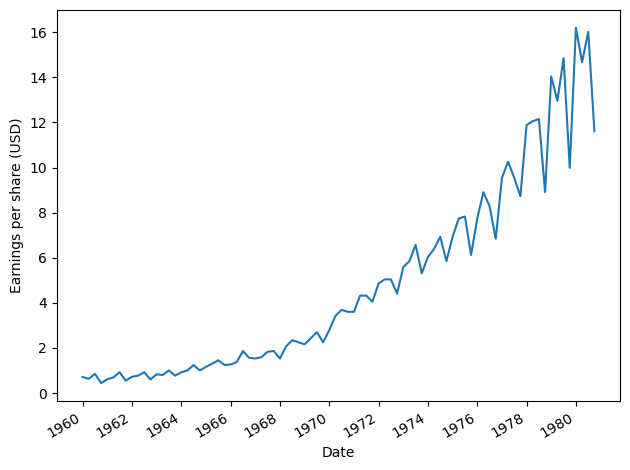

In [3]:

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/maukanmir/Documents/Machine-Learning/AI-ML-Textbooks/AI-ML-Learning/Data/jj.csv")


fig, ax = plt.subplots()
 
ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
 
plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
 
fig.autofmt_xdate()
plt.tight_layout()

In [5]:
ad_fuller_result = adfuller(df['data'])
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574686
p-value: 1.0


In [6]:
eps_diff = np.diff(df['data'], n=1)
 
ad_fuller_result = adfuller(eps_diff)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804626
p-value: 0.9088542416911305


#### This results in an ADF statistic of –0.41 and a p-value of 0.9. Again, the ADF statistic is not a large negative number, and the p-value is larger than 0.05. Therefore, we cannot reject the null hypothesis and we must conclude that after a first-order differencing, the series is not stationary.

Let’s try differencing again to see if the series becomes stationary:

In [7]:
eps_diff2 = np.diff(eps_diff, n=1)
 
ad_fuller_result = adfuller(eps_diff2)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793186
p-value: 0.006051099869603058


#### This results in an ADF statistic of –3.59 and a p-value of 0.006. Now that we have a p-value smaller than 0.05 and a large negative ADF statistic, we can reject the null hypothesis and conclude that our series is stationary. It took two rounds of differencing to make our data stationary, which means that our order of integration is 2, so d = 2.

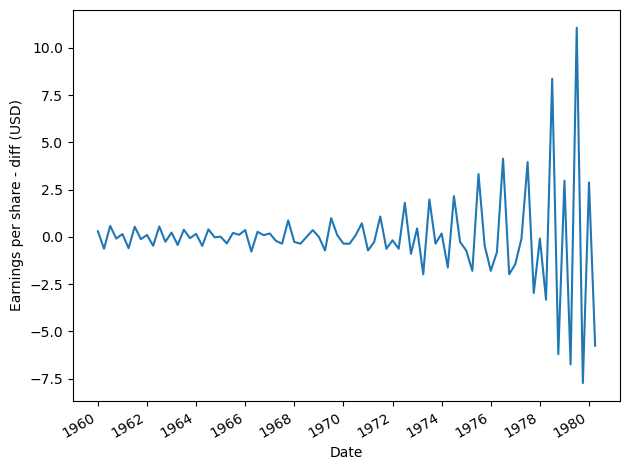

In [8]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

#### To fit the many ARIMA(p,d,q) models, we’ll define the optimize_ARIMA function. It is almost identical to the optimize_ARMA function that we defined in chapter 6, only this time we’ll add the order of integration d as an input to the function. The remainder of the function stays the same, as we fit the different models and order them by ascending AIC in order to select the model with the lowest AIC. The optimize_ARIMA function is shown in the following listing.

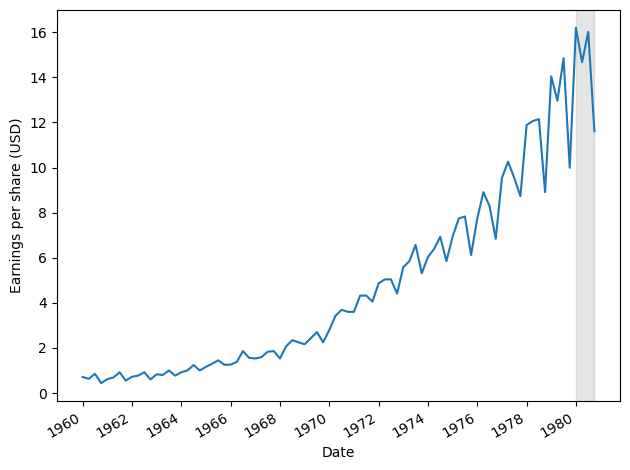

In [9]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [12]:
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [13]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64985/4280975418.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found

,"(p,q)",AIC
0,"(3, 3)",115.277017
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430628
4,"(0, 3)",194.654716
5,"(0, 2)",209.274500
6,"(2, 3)",220.666793
7,"(1, 3)",228.267817
8,"(1, 2)",228.935804
9,"(2, 2)",229.974697


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.639
Date:                Fri, 19 Jul 2024   AIC                            115.277
Time:                        17:42:06   BIC                            131.774
Sample:                             0   HQIC                           121.881
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9992      0.036    -27.563      0.000      -1.070      -0.928
ar.L2         -0.9872      0.040    -24.735      0.000      -1.065      -0.909
ar.L3         -0.9763      0.026    -38.281      0.0

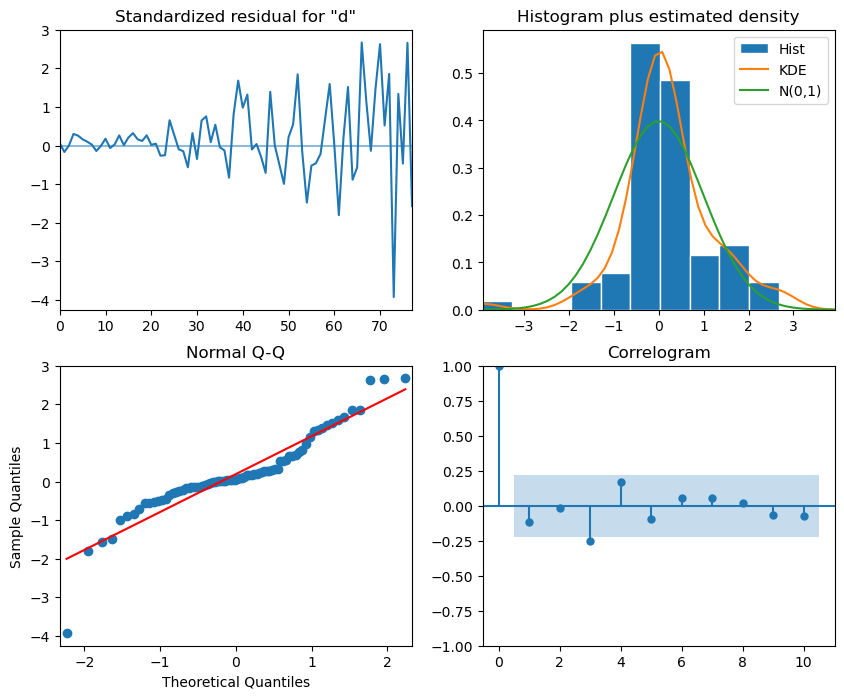

In [15]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())
 
model_fit.plot_diagnostics(figsize=(10,8));    

#### In figure 7.7, the top-left plot shows the residuals over time. While there is no trend in the residuals, the variance does not seem to be constant, which is a discrepancy in comparison to white noise. At the top right is the distribution of the residuals. We can see it is fairly close to a normal distribution. The Q-Q plot leads us to the same conclusion, as it displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. Finally, by looking at the correlogram at the bottom right, we can see that a coefficient seems to be significant at lag 3. However, since it is not preceded by any significant autocorrelation coefficients, we can assume that this is due to chance. Therefore, we can say that the correlogram shows no significant coefficients after lag 0, just like white noise.

#### Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, as it means that the model’s errors are random.

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox
 
residuals = model_fit.resid
 
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
 
print(pvalue)

lb_pvalue


In [20]:
test = df.iloc[-4:]
 
test['naive_seasonal'] = df['data'].iloc[76:80].values 

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64985/2376514307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = df['data'].iloc[76:80].values


In [21]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean
 
test['ARIMA_pred'] = ARIMA_pred   

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64985/2568665910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


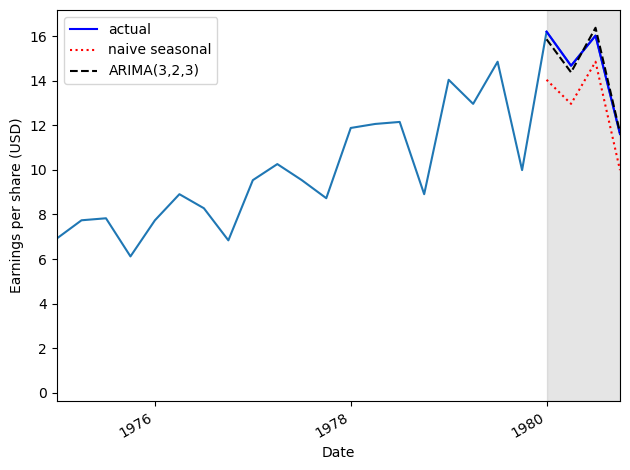

In [22]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [23]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.725092174463665


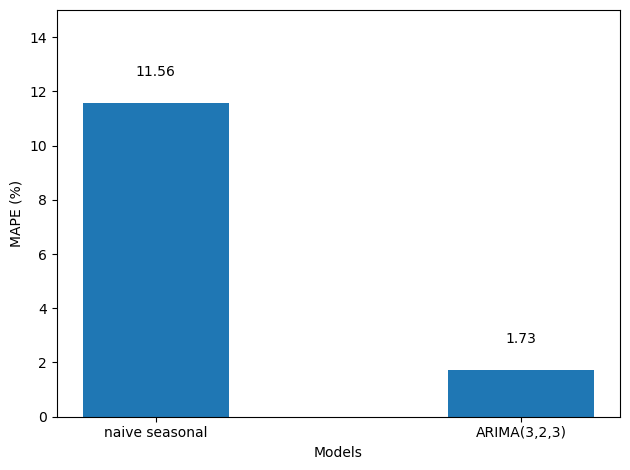

In [25]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

#### To apply the ARIMA(p,d,q) model, we added an extra step to our general modeling procedure, which simply involves finding the value for the order of integration. This corresponds to the minimum number of times a series must be differenced to become stationary.

#### Now we can add another layer to the ARIMA(p,d,q) model that allows us to consider yet another property of time series: seasonality. We have studied the Johnson & Johnson dataset enough times to realize that there are clear cyclical patterns in the series. To integrate the seasonality of a series in a model, we must use the seasonal autoregressive integrated moving average (SARIMA) model, or SARIMA(p,d,q)(P,D,Q)m. This will be the subject of the next chapter.

## Summary

- The autoregressive integrated moving average model, denoted as ARIMA(p,d,q), is the combination of the autoregressive model AR(p), the order of integration d, and the moving average model MA(q).

- The ARIMA(p,d,q) model can be applied on non-stationary time series and has the added advantage of returning forecasts in the same scale as the original series.

- The order of integration d is equal to the minimum number of times a series must be differenced to become stationary.

- An ARIMA(p,0,q) model is equivalent to an ARMA(p,q) model.